In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

### My Implementation

In [2]:
img = cv2.imread("../../../sphinx.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
b, g, r = img[:, :, 0], img[:, :, 1], img[:, :, 2]



shape = r.shape



b = (b / 255).flatten()

g = (g / 255).flatten()

r = (r / 255).flatten()



def gamma_correction(value):

    value = np.asarray(value)

    

    condition = value <= 0.04045

    res = np.where(

        condition,

        value / 12.92,

        ((value + 0.055) / 1.055) ** 2.4

    )

    

    return res



r = gamma_correction(r)

g = gamma_correction(g)

b = gamma_correction(b)



rgb = np.array([r, g, b])

converting_mat = [[0.412453, 0.357580, 0.180423],

                  [0.212671, 0.715160, 0.072169],

                  [0.019334, 0.119193, 0.950227]]

x, y, z = np.matmul(converting_mat, rgb)

In [3]:
# Calculate the chromaticity coordinates
u_dash = 4 * x / (x + 15 * y + 3 * z)
v_dash = 9 * y / (x + 15 * y + 3 * z)

un = 0.19793943
vn = 0.46831096

# Calculate L
y_gt_idx = np.argwhere(y > 0.008856)
y_le_idx =np.argwhere(y <= 0.008856)

l = np.zeros_like(y)
l[y_gt_idx] = (116 * y[y_gt_idx] ** (1/3)) - 16
l[y_le_idx] = 903.3 * y[y_le_idx]

# Calculate u and v
u = 13 * l * (u_dash - un)
v = 13 * l * (v_dash - vn)

In [4]:
l = 255 / 100 * l
u = 225 / 354 * (u + 134)
v = 255 / 262 * (v + 140)

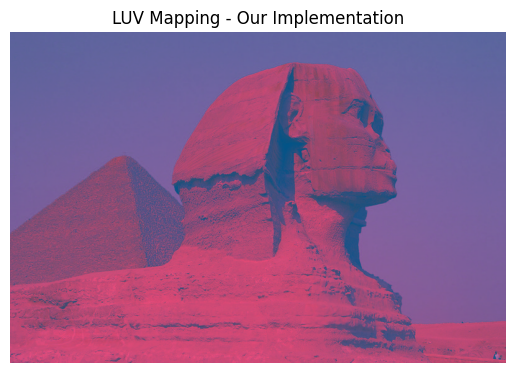

In [12]:
l = l.reshape(shape)
u = u.reshape(shape)
v = v.reshape(shape)

luv = np.array([l, u, v], np.int64).T
luv = np.fliplr(np.rot90(luv, 3))
cv2.imwrite("luv_out.jpg", luv)
plt.imshow(luv)
plt.title("LUV Mapping - Our Implementation")
plt.axis('off')
plt.show()

In [6]:
luv

array([[[ 92,  98, 158],
        [ 93,  98, 158],
        [ 93,  98, 158],
        ...,
        [ 90, 101, 159],
        [ 90, 101, 159],
        [ 91, 101, 159]],

       [[ 91,  98, 157],
        [ 92,  98, 158],
        [ 92,  98, 158],
        ...,
        [ 90, 101, 159],
        [ 90, 101, 159],
        [ 90, 101, 159]],

       [[ 90,  98, 157],
        [ 91,  98, 157],
        [ 92,  98, 156],
        ...,
        [ 89, 101, 159],
        [ 90, 101, 159],
        [ 90, 101, 159]],

       ...,

       [[185,  73, 119],
        [192,  73, 122],
        [192,  74, 122],
        ...,
        [196,  74, 114],
        [197,  74, 114],
        [196,  73, 114]],

       [[213,  73, 122],
        [189,  74, 122],
        [158,  74, 124],
        ...,
        [187,  73, 113],
        [189,  72, 112],
        [190,  72, 112]],

       [[214,  74, 122],
        [199,  74, 124],
        [164,  75, 124],
        ...,
        [180,  72, 111],
        [179,  71, 111],
        [176,  71, 111]]

### OpenCV Function

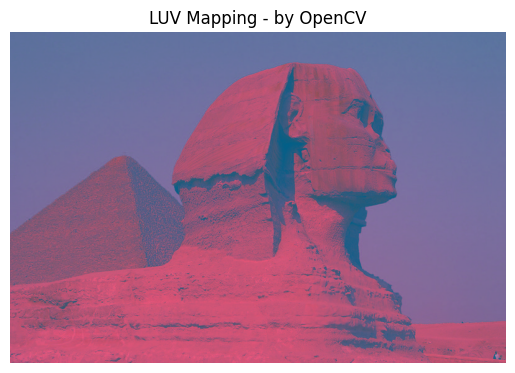

In [11]:
image = cv2.imread("../../../sphinx.jpg")
luv_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)


cv2.imwrite("luv_out_cv.jpg", luv_image)

plt.imshow(luv_image)
plt.title("LUV Mapping - by OpenCV")
plt.axis('off')
plt.show()

In [8]:
luv_image[215]

array([[113, 110, 157],
       [113, 110, 157],
       [113, 110, 157],
       ...,
       [113, 111, 159],
       [112, 111, 159],
       [112, 111, 159]], dtype=uint8)

---

In [9]:
def rgb_to_xyz(rgb_image):
    # RGB to XYZ transformation matrix (assuming D65 illuminant)
    # This matrix is for sRGB to CIE 1931 color space conversion
    rgb_to_xyz_matrix = np.array([
        [0.4124564, 0.3575761, 0.1804375],
        [0.2126729, 0.7151522, 0.0721750],
        [0.0193339, 0.1191920, 0.9503041]
    ])

    # Linearize the RGB values
    linear_rgb = np.where(rgb_image > 0.04045,
                          np.power((rgb_image + 0.055) / 1.055, 2.4),
                          rgb_image / 12.92)

    # Apply the transformation matrix to convert RGB to XYZ
    xyz_image = np.dot(linear_rgb, rgb_to_xyz_matrix.T)

    return xyz_image


# Function to convert XYZ to LUV
def xyz_to_luv(xyz_image):
    # D65 reference white point in XYZ space
    Xr, Yr, Zr = 95.047, 100.000, 108.883

    # Calculate u' and v' for the reference white point
    ur = (4 * Xr) / (Xr + 15 * Yr + 3 * Zr)
    vr = (9 * Yr) / (Xr + 15 * Yr + 3 * Zr)

    # Unpack the XYZ image
    X, Y, Z = xyz_image[..., 0], xyz_image[..., 1], xyz_image[..., 2]

    # Compute L*
    L = np.where(Y > 0.008856,
                 116 * np.cbrt(Y) - 16,
                 903.3 * Y)

    # Compute u' and v'
    u_prime = (4 * X) / (X + 15 * Y + 3 * Z)
    v_prime = (9 * Y) / (X + 15 * Y + 3 * Z)

    # Compute u and v
    u = 13 * L * (u_prime - ur)
    v = 13 * L * (v_prime - vr)

    # Stack L, u, and v to create the LUV image
    luv_image = np.stack([L, u, v], axis=-1)

    return luv_image


# Load the image using OpenCV
image_path = 'sphinx.jpg'  # Update with your image path
rgb_image = cv2.imread(image_path)
# Convert from BGR to RGB
rgb_image = cv2.cvtColor(rgb_image, cv2.COLOR_BGR2RGB)

# Normalize RGB values to [0, 1]
normalized_rgb_image = rgb_image / 255.0

# Convert RGB to XYZ
xyz_image = rgb_to_xyz(normalized_rgb_image)

# Convert XYZ to LUV
luv_im = xyz_to_luv(xyz_image)

cv2.imwrite("chat.jpg", luv_im)

# Display the LUV image using Matplotlib
plt.imshow(luv_image.astype(np.float32))  # We use float32 to avoid overflow
plt.title("LUV Image")
plt.show()
luv_im

error: OpenCV(4.8.1) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'
